In [1]:
%matplotlib inline

import os
import pandas as pd
import json
import folium
import jenkspy

# Question 1

## Load the data

We chose to use the long-term unemployment rate, by gender: http://ec.europa.eu/eurostat/web/products-datasets/-/tsdsc330 (last update: 10/27/17) because it is the only data source containing results for european countries including Switzerland. This will allow making a comparison of the unemployment rate and be sure that data was computed using the same method.

We choosed to used the latest data for the 2016 year. It's the latest full-month year. This dataset contains the unemployment rate by gender, but we will use only the total. We will drop the row with no valid information (missing data, and break in time series).

In [2]:
dataset_path = 'Long-term unemployment rate, by sex.tsv'
europe_unemploy_data = pd.read_csv(dataset_path, sep='\t')
europe_unemploy_data = europe_unemploy_data.set_index('geo\\time')

# We take the total unemploy
europe_unemploy_data = europe_unemploy_data[europe_unemploy_data['sex '] == 'T '] 

# Drop the non-numeric values
europe_unemploy_data = europe_unemploy_data[pd.to_numeric(europe_unemploy_data['2016'], errors='coerce').notnull()] 
europe_unemploy_data['2016'] = pd.to_numeric(europe_unemploy_data['2016'], errors='coerce')
europe_unemploy_data.head()

,indic_em,age,unit,sex,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
geo\time,,,,,,,,,,,,,,,,,,,,,
AT,LTU,Y15-74,PC_ACT,T,:,:,:,:,:,:,...,1.3 b,1.0,1.2,1.2,1.2,1.2,1.3,1.5,1.7,1.9
BE,LTU,Y15-74,PC_ACT,T,:,:,:,4.9 b,3.8,3.2 b,...,3.8,3.3,3.5,4.0,3.5,3.4,3.9,4.3,4.4,4.0
BG,LTU,Y15-74,PC_ACT,T,:,:,:,:,9.6,12.6 b,...,4.1,2.9,3.0,4.7 b,6.3 b,6.8,7.4,6.9,5.6,4.5
CH,LTU,Y15-74,PC_ACT,T,:,:,:,:,:,:,...,:,:,:,1.6 b,1.6,1.5,1.5,1.7,1.8,1.8
CY,LTU,Y15-74,PC_ACT,T,:,:,:,:,:,:,...,0.7,0.5,0.6 b,1.3,1.6,3.6,6.1,7.7,6.8,5.8


We modify the country code of Greece and United Kingdom to use them with the topo.json

In [3]:
europe_unemploy_data.loc['GB'] = europe_unemploy_data.loc['UK']
europe_unemploy_data.loc['GR'] = europe_unemploy_data.loc['EL']
europe_unemploy_data.drop(['UK', 'EL'])

print('Country codes renamed!')

Country codes renamed!


## Create the colormap

We choosed natural breaks for the colormap because the data is not evenly distributed. This breaks method arranges each groupings so there is less variation in each class. So in each class, the number of element is not too small and the range is not too large. The color will be more representative of the class.

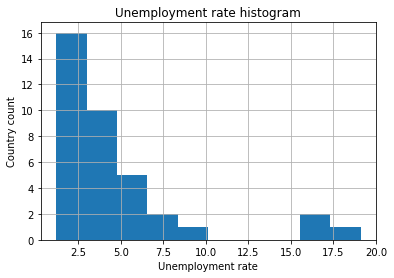

In [4]:
plot = europe_unemploy_data['2016'].hist()
plot.set_ylabel('Country count')
plot.set_xlabel('Unemployment rate')
plot.set_title('Unemployment rate histogram')

To make our life easier and not reimplement the wheel, we will use [jenkspy](https://github.com/mthh/jenkspy).

In [5]:
# We choose to use 5 classes to avoid too many different colors. It is indeed important to be able to differentiate the
# different color tones. Using more than 5 classes gives poor results.
breaks = jenkspy.jenks_breaks(europe_unemploy_data['2016'], nb_class=5)
breaks

[1.2, 3.0, 5.0, 6.7, 9.5, 19.1]

In [6]:
from branca.colormap import linear

colormap = linear.OrRd.scale(
    europe_unemploy_data['2016'].min(),
    europe_unemploy_data['2016'].max())

colormap = colormap.to_step(
    index=breaks
)

colormap.caption = 'Unemployment rate'
colormap

Since the unemployment ratio is not something positive for the country, we chose the colormap to from yellow to red when the ratio is high. The red is an agressive color which is often related to *bad* events, contrary to green.

## Create the choropleth

In [7]:
topo_path = r'topojson/europe.topojson.json'
topo_json_data = json.load(open(topo_path))

def style_func(country):    
    country_id = country['id']
    if country_id in europe_unemploy_data.index:
        unemploy_ratio = europe_unemploy_data.loc[country_id]['2016']
        return {
            'fillColor' : colormap(unemploy_ratio),
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5',
            'fillOpacity': 0.9 # We leave some transparency so we can read countries name
        }
    
    return { # Countries with missing data will be displayed in light, transparent grey
        'fillColor' : '#000000',
        'weight' : '0', 
        'fillOpacity': 0.3
    }


europe_map = folium.Map([53, 12], tiles='cartodbpositron', zoom_start=4)
folium.TopoJson(topo_json_data, 
                'objects.europe', 
                name='Europe Unemploy ratio',
                style_function=style_func
).add_to(europe_map)

colormap.add_to(europe_map)

europe_map

## Add some interactivity

The map gives good insights, however we can make it more interactive. Using a geojson file (because of the too many limitations of the topojson feature of Folium), we can make area clickable so we can desplay the exact unemployment rate in the given area.

In [8]:
geo_path = r'europe.geojson.json'
geo_json_data = json.load(open(geo_path))

# For each country in the geo json file, we add some interactive features
for feature in geo_json_data['features']:    
    country_id = feature["properties"]["ISO2"]
    if country_id not in europe_unemploy_data.index:
        continue
        
    country_name = feature["properties"]["NAME"]
    unemployment_rate = europe_unemploy_data.loc[country_id]['2016']

    c = folium.GeoJson(
        feature, name=country_name,
        style_function = lambda a: {'weight': 0, 'fillOpacity':0},
        highlight_function = lambda a: {'fillColor': '#ffaf00','color': 'black', 'weight': 3,'dashArray': '5, 5'}
    )
    c.add_child(
        folium.Popup(
            '<span style="font-size: 1.5em">' + country_name + '</span><br />' +
            '<strong>Long term unemployment:</strong> ' + str(unemployment_rate) + '%'
    ))
    c.add_to(europe_map)

europe_map

## Colormap efficiency

We see that our colormap worked well. The outlier countries which are Greece and Republic of Macedonia, are revealed with an agressive dark red. They both have a high unemployment rate.  

## Switzerland VS Europe

Looking to the map, the Switzerland unemployment ratio is part of the lowest ones. This is well represented with a soft light color. We can make sure that this insight is realistic by checking the raw numbers:

In [9]:
print('European union (28 countries): ' + str(europe_unemploy_data['2016']['EU28']))
print('Switzerland: ' + str(europe_unemploy_data['2016']['CH']))

European union (28 countries): 4.0
Switzerland: 1.8


The data vizualisation was giving realistic insights.

# Question 2

**Gathering data**

We've used the [amstat](https://www.amstat.ch/v2/index.jsp) website and extracted the most recent-  September 2017 dataset for unemployment across swiss cantons. We've used the filter to select the data for 

- Unemployment rate
- Unemployed people without Jobs
- Total Unemployed people

**Data Cleaning** : 

- The figures provided are with periods(') that are removed to get ints.
- Modified Unemployment rate is defined as instructed in the tutorial: 

<br>
<center>
$\text{Modified Unemployment rate}$ = $\frac{\text{#Unemployed without Jobs}}{\text{Active Population}}$ <br>
$\text{Unemployment rate}$ = $\frac{\text{#Unemployed agnostic to Jobs}}{\text{Active Population}}$ <br>
</center>
So, using : 
<center>
$\text{Modified Unemployment rate}$ =   $\frac{\text{Unemployment rate}*\text{#Unemployed without Jobs}}{\text{#Unemployed agnostic to Jobs}}$

In [10]:
pd.options.mode.chained_assignment = None

swiss_topo_path = r'topojson/ch-cantons.topojson.json'
swiss_topo_json_data = json.load(open(swiss_topo_path))

swiss_data_raw = pd.read_excel('q2.xlsx')
swiss_data = swiss_data_raw[:-1]

names = [obj['properties']['name'] for obj in swiss_topo_json_data['objects']['cantons']['geometries']]
swiss_data['Topo name'] = names
swiss_data = swiss_data.set_index('Topo name')
swiss_data['Jobseekers'] = [int("".join(l)) for l in [k.split('\'') for k in swiss_data['Jobseekers']]]
swiss_data['Jobseekers not unemployed'] = [int("".join(l)) for l in [k.split('\'') for k in swiss_data['Jobseekers not unemployed']]]

swiss_data['Mod Unemployment rate'] = [(r*j)/(j-hasj) for r,j,hasj in zip(swiss_data['Unemployment rate'],swiss_data['Jobseekers'],swiss_data['Jobseekers not unemployed'])]   

In [11]:
all_unemp = round(pd.concat([swiss_data['Unemployment rate'],swiss_data['Mod Unemployment rate']]),3)
classes = jenkspy.jenks_breaks(all_unemp , nb_class=4)
swiss_data['Mod Unemployment rate'] = round(swiss_data['Mod Unemployment rate'],3)

**Different shade maps for visualization**

We've used a yellow to orange map to maining a bit of consistency with color in rest of the europe. Since, the unemployment rates in switzerland are relatively low, so orange is better suited than red for the highest possible rates.

In [12]:
colormap_swiss = linear.OrRd.scale(
    all_unemp.min(),
    all_unemp.max())

colormap_swiss = colormap_swiss.to_step(
    index=classes
)

colormap.caption = 'Unemployment rate Switzerland'
colormap_swiss

**Map 1** : A chloropleth map overlaying the unemployment rates as defined by the government

In [14]:
def swiss_style_func(canton):
    prop = {'fillColor' : colormap_swiss(swiss_data['Unemployment rate'][canton['properties']['name']]),
                    'color': 'black',
                    'weight': 1,
                    'dashArray': '5, 5',
                    'fillOpacity': 1,
                   }
    return prop

swiss_map = folium.Map([46.8, 8.3], tiles='cartodbpositron', zoom_start=8)

folium.TopoJson(swiss_topo_json_data, 
                 'objects.cantons', 
                name='Swiss Unemploy ratio (By govt.)',
                style_function=swiss_style_func
                
).add_to(swiss_map)

colormap_swiss.add_to(swiss_map)

folium.LayerControl().add_to(swiss_map)
swiss_map

**Trends** : To start, it can be seen that unemployment rate varies quite widely and has a difference of over 8 times between the lowest and the highest rates, with, the eastern regions having the lowest and the western the highest unemployment rate.

Which brings to the second trend, of a gradual fall in the rates from the west to the east which is quite regular in trend! Wit St. Moritz being the best off along with Zurich and unfortunately, Vaud and Geneva falling on the lower side.

**Map 2** : A chloropleth map overlaying the unemployment rate that is defined by the number of people who are registered 
    as unemployed and also do not have a job over the total active population. It is calculated as described above.

In [15]:
def swiss_style_func_mod(canton):
    prop = {
        'fillColor' : colormap_swiss(swiss_data['Mod Unemployment rate'][canton['properties']['name']]),
        'color': 'black',
        'weight': 1,            
        'dashArray': '5, 5',            
        'fillOpacity': 1,
    }
    
    return prop

swiss_map_mod = folium.Map([46.8, 8.3], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(
    swiss_topo_json_data, 
    'objects.cantons', 
    name='Mod Unemploy ratio',
    style_function=swiss_style_func_mod            
).add_to(swiss_map_mod)

colormap_swiss.add_to(swiss_map_mod)
folium.LayerControl().add_to(swiss_map_mod)
swiss_map_mod

**Observations:**

- It is quite surprising to see that the trend is completely changed. From an east to west trend, the modified map has an boundary to the core trend. The new measure is the highest near the boundaries of the map and improves as one moves into the core of switzerland. 
- The cantons of Zurich and Lucern still remain afloat however the regions near St. Gallen and Thungau have completely changed.
- There is a general decrease in the modified unemployment rate which is expected because of the definition. However, the decrease isn't uniform and again varies widely.
- An interesting hypothesis would be that people in Zurich in the lower middle and lower working classes are in general happier with their current jobs and hence not registered with unemployment office compared to the people near the boundaries. But it would of course require more investigation. 

# Question 3

## Inequalities between strangers and swiss people

To answer questions for this part, we will use the Amstat website (in German) and get the unemployment from section 2.1 (*Taux de chômage*, *Arbeitslosenquoten*) and get information with nationality disparity and divided per canton.

We choose data for september 2017, only registered unemployed people. As we will only compare data for Switzerland, this won't be an issue if we don't use the same data as in previous questions.

In [ ]:
raw_df = pd.read_csv('q3.csv', encoding='UTF-16') # Parsing using default UTF-8 was giving an error.
raw_df = raw_df.drop(raw_df.index[0]) # Removing second row labels.

df = raw_df.set_index(['Kanton', 'Nationalität'])
df = df[['September 2017']] # Only keeping september results
df[['September 2017']] = df[['September 2017']].apply(pd.to_numeric) # Converting objects to numbers
job_seekers = df.groupby(['Nationalität', 'Kanton']).sum() # Final values

job_seekers

Notice that *Ausländer* means *strangers* and *Schweizer* is for the *swiss people*.

We have two ways to display data in a meaningful way. The first one could be to create two choropleth and let the final user choose which one he wants to display. He could be able to switch from one to the other in one click, this would be useful to see the evolution visually.

The other solution could be to compute a ratio to determine in which cantons the difference between strangers and swiss unemployment is the most important. This will be done in a second time.

In [ ]:
# Calculating the breaks, we use the same conventions as in previous questions.
breaks = jenkspy.jenks_breaks(job_seekers['September 2017'], nb_class=5)

colormap_strangers = linear.OrRd.scale(
    job_seekers['September 2017'].min(),
    job_seekers['September 2017'].max())

colormap_strangers = colormap_strangers.to_step(
    index=breaks
)

colormap_strangers.caption = 'Unemployment rate'
colormap_strangers

In [ ]:
strangers = job_seekers[job_seekers.index.get_level_values('Nationalität') == 'Ausländer']
swiss = job_seekers[job_seekers.index.get_level_values('Nationalität') == 'Schweizer']

def map_name(canton):
    '''
    Translates canton's name to get a match between topoJSON file and the dataset.
    '''
    
    translations = dict({
        'Bern/Berne': 'Bern',
        'Fribourg': 'Freiburg',
        'Graubünden/Grigioni': 'Graubünden',
        'Ticino': 'Tessin',
        'Vaud': 'Waadt',
        'Valais/Wallis': 'Wallis',
        'Valais': 'Wallis', # Will be used in next question
        'Neuchâtel': 'Neuenburg',
        'Genève': 'Genf'
    })
    
    if canton in translations.keys():
        return translations[canton]
    
    return canton

def swiss_canton_style_func(canton, nationality):
    '''
    Generic style function, used to get the color for each canton depending on the nationality.
    '''
    
    name = map_name(canton['properties']['name']) 
    color = colormap_strangers(job_seekers[job_seekers.index.get_level_values('Kanton') == name]['September 2017'][nationality][0])
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 1
    }

def swiss_swiss_style_func(canton):
    '''
    Get the color for swiss people.
    '''
    return swiss_canton_style_func(canton, 'Schweizer')

def swiss_stranger_style_func(canton):
    '''
    Get the color for strangers.
    '''
    return swiss_canton_style_func(canton, 'Ausländer')

swiss_map = folium.Map([46.8, 8.3], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(swiss_topo_json_data, 
                'objects.cantons', 
                name='Swiss Unemploy ratio',
                style_function=swiss_swiss_style_func
).add_to(swiss_map)

folium.TopoJson(swiss_topo_json_data, 
                'objects.cantons', 
                name='Strangers Unemploy ratio',
                style_function=swiss_stranger_style_func
).add_to(swiss_map)

colormap_strangers.add_to(swiss_map)
folium.LayerControl().add_to(swiss_map)

print('Use the icon on the top right to select strangers / swiss unemployment rate. By default, the strangers rate'
     'is displayed (even if the two checkboxes are checked).')

swiss_map

As said before, another solution is to compute the ratio for each canton, to see in which one the difference of unemployment between strangers and swiss people is the most important.

In [ ]:
# We compute the ratio by performing a simple division of the two datasets
ratio = strangers.reset_index().set_index(['Kanton'])[['September 2017']] / swiss.reset_index().set_index(['Kanton'])[['September 2017']]

# We compute the breaks
breaks = jenkspy.jenks_breaks(ratio['September 2017'], nb_class=5)

colormap_ratio = linear.OrRd.scale(
    ratio['September 2017'].min(),
    ratio['September 2017'].max())

colormap_ratio = colormap_ratio.to_step(
    index=breaks
)

colormap_ratio.caption = 'Unemployment ratio between swiss and strangers'

def swiss_ratio_style_func(canton):
    name = map_name(canton['properties']['name']) 
    color = colormap_ratio(ratio[ratio.index.get_level_values('Kanton') == name]['September 2017'][0])
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 1
    }

ratio_map = folium.Map([46.8, 8.3], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(swiss_topo_json_data, 
                'objects.cantons', 
                name='Swiss/Strangers Unemploy ratio',
                style_function=swiss_ratio_style_func
).add_to(ratio_map)

colormap_ratio.add_to(ratio_map)

ratio_map

## Adding some interactivity

In [ ]:
geo_path = r'ch-cantons.geojson.json'
geo_json_data = json.load(open(geo_path, encoding='utf-8'))

for feature in geo_json_data['features']:
    
    canton_name = feature["properties"]["name"]
    canton_name = map_name(canton_name)
    if canton_name not in job_seekers.loc['Ausländer'].index:
        continue
        
    auslander_unemployment_rate = job_seekers.loc['Ausländer'].loc[canton_name][0]
    schweizer_unemployment_rate = job_seekers.loc['Schweizer'].loc[canton_name][0]


    c = folium.GeoJson(
        feature, name=country_name,
        style_function = lambda a: {'weight': 0, 'fillOpacity':0},
        highlight_function = lambda a: {'fillColor': '#ffaf00','color': 'black', 'weight': 3,'dashArray': '5, 5'}
    )
    c.add_child(
        folium.Popup(
            '<span style="font-size: 1.5em">' + canton_name + '</span>' +
            '<br /> <strong>Foreigner:</strong> ' + str(auslander_unemployment_rate) +
            '%<br /> <strong>Swiss people:</strong> ' + str(schweizer_unemployment_rate) + '%'
    ))
    c.add_to(ratio_map)

ratio_map

We get a very informative insight here. When comparing the two previous colormaps by clicking between them, we can have the feeling that inequalities are high between the north cantons. This is in fact biased because of the classes used to color the map (especially if strangers and swiss people are in the same class but with very different values).
This is the case for *Uri*'s canton (in the middle of the map here). Unemployement is very low in this canton (0.4 for swiss people VS 2.1 for strangers). The ratio is, however, very high (5.25). This was impossible to see on previous map, it is now really clear.

Moreover, we could expect inequalities to be higher when there are less people living in the cantons (considering swiss people are favorised on hiring).

## Differences between age groups

We use a new file, now from section 1.1 on Amstat website (because precalculated ratios does not allow to use more than one criteria between nationality and age groups). We chose the same month and the same criteria.

In [ ]:
df = pd.read_csv('q3_2.csv', encoding='UTF-16')

df = df.rename(columns={'Unnamed: 3': 'Age groups'})
df = df.drop(df.index[0]) # Removing second row label
df['September 2017'] = df['September 2017'].str.replace('\'','')
raw_df['September 2017.1'] = raw_df['September 2017.1'].str.replace('\'','')

print('Data used in **previous** question:')
print(raw_df.loc[1]) # This df was used in previous question
print('\nData used in **current** question:')
print(df.iloc[3])

df = df[~(df == 'Gesamt').any(axis=1)] # Removing totals

We have here the guarantee that data is coming from the same source as number of unemployed people is the same (12111 in the above example). We will use the raw number to recalculate the ratios based on the rates we get from the previous file.

In [ ]:
df[['September 2017']] = df[['September 2017']].apply(pd.to_numeric) # Converting objects to numbers

def normalize(row):
    '''
    Using the old dataset, this function calculates the proportion of unemployed
    people for each age group.
    '''
    
    # We match data from the previous dataset (raw_df) with the current one (df)
    rate_row = raw_df.loc[(raw_df['Kanton'] == row['Kanton']) & (raw_df['Nationalität'] == row['Nationalität'])]
    total = int(rate_row['September 2017.1'].iloc[0]) # We get the total number of unemployed people in the category
    rate = float(rate_row['September 2017'].iloc[0]) # We also get the corresponding rate
    
    return row['September 2017'] / total * rate # We can now calculate the new rate

df['September 2017'] = df.apply(normalize, axis=1)

In [ ]:
df = df.set_index(['Altersklassen 15-24, 25-49, 50 und mehr', 'Kanton'])
df.head()

As you can see, we now have the rate for each age group. We can finally plot it for each canton in a bar plot (as asked). We use three bar plots (one for each age group) so it is more readable.

In [ ]:
for i in range(1,4):
    age_range = df.loc[str(i)]
    plot = pd.concat(
        [
            age_range[age_range['Nationalität'] == 'Ausländer']['September 2017'].rename('Stangers'),
            age_range[age_range['Nationalität'] == 'Schweizer']['September 2017'].rename('Swiss')
        ], axis=1
    ).plot(kind='bar', figsize=(17, 5), title=age_range['Age groups'][0])